# Weather Data
### by Line van Nifterik and Stoil Iliev

Packages:

In [2]:
!pip install numpy pandas matplotlib seaborn scikit-learn scipy haversine networkx

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


Imports:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import haversine
import networkx as nx
import seaborn as sns
from scipy.linalg import eigh
import sklearn
import scipy
import warnings
warnings.filterwarnings('ignore')

Import files

In [29]:
# Import locally
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

In [4]:
class WeatherGraphProcessor:
  def __init__(self, stations_file="weather_stations.csv", data_file="weather_data.csv"):
    self.stations_df = None
    self.weather_df = None
    self.load_data(stations_file, data_file)
    self.GWS = None # Weather station graph
    self.eigenvalues = None
    self.eigenvects = None

  def load_data(self, stations_file, data_file):
    try:
      # Load weather station data
      self.stations_df = pd.read_csv(stations_file)
      print(f"Loaded {len(self.stations_df)} weather stations")

      # Load weather measurement data
      self.weather_df = pd.read_csv(data_file)
      print(f"Loaded {len(self.weather_df)} weather measurements")

      # Display basic info
      print("\nWeather stations columns:", list(self.stations_df.columns))
      print("Weather data columns:", list(self.weather_df.columns))
      print(f"Date range: {self.weather_df['DATE'].min()} to {self.weather_df['DATE'].max()}")

    except FileNotFoundError:
      print("File not found")

  def construct_weather_station_graph(self, alpha, beta, sparsification, k, threshold):
    # alpha: distance decay
    # beta: alt diff decay
    # sparsification: knn, threshold, none?
    # k: kNN number
    # threshold: for weight-based sparisification

    n_stations = len(self.stations_df)
    W = np.zeros((n_stations, n_stations))

    # get coordinates / altitudes
    lats = self.stations_df['LAT'].values
    lons = self.stations_df['LONG'].values
    heis = self.stations_df['HEI'].values

    # Compute pairwise distances
    for i in range(n_stations):
      for j in range(n_stations):
        if i != j:
          # Geographic
          d_ij = haversine.haversine((lats[i], lons[i]), (lats[j], lons[j]), unit=haversine.Unit.KILOMETERS)
          # Altitude difference
          h_ij = abs(heis[i] - heis[j]) / 1000  # Convert to km
          # Weight function
          W[i, j] = np.exp(-alpha * d_ij - beta * h_ij)

    # sparsification
    if sparsification == 'knn':
      # k-NN
      W_sparse = np.zeros_like(W)
      for i in range(n_stations):
        neighbors = np.argsort(W[i, :])[-k-1:-1] # Exclude self (highest weight)
        W_sparse[i, neighbors] = W[i, neighbors]
      # Make symmetric (mutual k-NN)
      W =(W_sparse + W_sparse.T) / 2

    elif sparsification == 'threshold':
      W[W < threshold] = 0

    # Store the graph
    self.GWS = W

    # Compute graph Laplacian and its eigendecomposition
    D = np.diag(np.sum(W, axis=1))
    L = D - W  # Combinatorial Laplacian

    # Compute eigenvalues and eigenvectors
    self.eigenvals, self.eigenvecs = eigh(L)

    print(f"Constructed weather station graph with {n_stations} nodes")
    print(f"Sparsification: {sparsification}, Non-zero edges: {np.sum(W > 0)}")
    print(f"Graph density: {np.sum(W > 0) / (n_stations * (n_stations - 1)):.3f}")

    return W

  def draw_weather_station_graph(self):
    if self.GWS is None:
      print("Weather station graph not constructed yet.")
      return

    G = nx.from_numpy_array(self.GWS)

    # Get positions for nodes (using station coordinates)
    pos = {i: (self.stations_df['LONG'][i], self.stations_df['LAT'][i]) for i in range(len(self.stations_df))}

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_size=10, width=0.1)
    plt.title("Weather Station Graph")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

Loaded 76 weather stations
Loaded 40921 weather measurements

Weather stations columns: ['ID', 'SITE', 'LAT', 'LONG', 'HEI', 'OP']
Weather data columns: ['ID', 'DATE', 'QUALITY', 'MIN_5CM', 'MIN_2M', 'MEAN_2M', 'MAX_2M', 'REL_HUMIDITY', 'MEAN_WIND_STRENGTH', 'MAX_WIND_SPEED', 'SUNSHINE', 'MEAN_CLOUDINESS', 'PRECIPITATION', 'MEAN_PRESSURE']
Date range: 1.0 to 3.0
Constructed weather station graph with 76 nodes
Sparsification: knn, Non-zero edges: 400
Graph density: 0.070


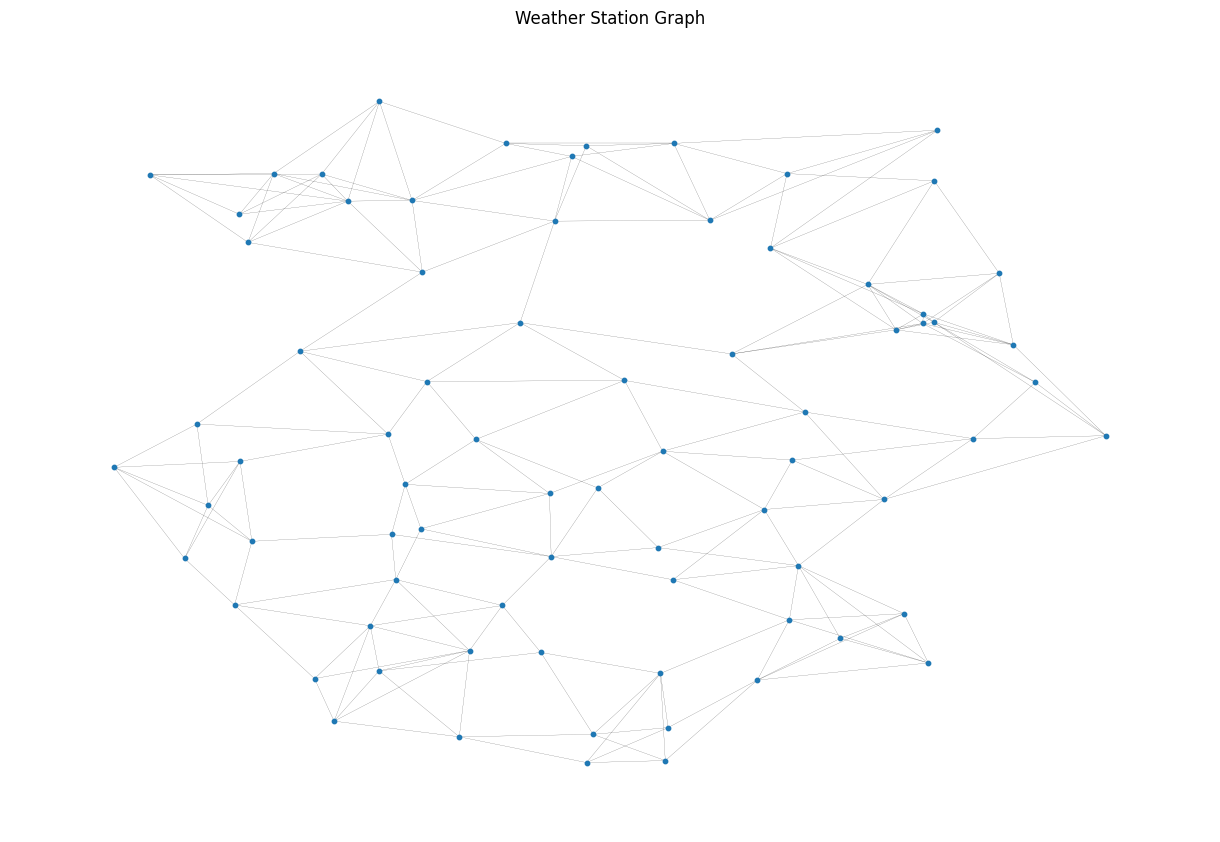

In [7]:
# Instantiate the WeatherGraphProcessor
weather_processor = WeatherGraphProcessor()

# Construct the weather station graph
# k-NN
weather_processor.construct_weather_station_graph(alpha=0.1, beta=0.001, sparsification="knn", k = 4, threshold=0.00001)
# Threshold
# weather_processor.construct_weather_station_graph(alpha=0.1, beta=0.001, sparsification='threshold', threshold=0.00001)

# Draw the graph
weather_processor.draw_weather_station_graph()

In [8]:
def get_A(G):
    A = nx.adjacency_matrix(G)
    A = A.astype('float')
    return(A)

def get_norm_L(G):
    L = nx.normalized_laplacian_matrix(G, weight=None)
    L = L.astype('float')
    return(L)

In [9]:
def construct_spacetime_graph(self, time_steps):
  if self.GWS is None:
    raise ValueError("Must construct weather station graph first")

  n_stations = self.GWS.shape[0]

  # # Create path graph for time (adjacency matrix)
  # A_GP = np.zeros((time_steps, time_steps))
  # for i in range(time_steps - 1):
  #   A_GP[i, i+1] = 1
  #   A_GP[i+1, i] = 1
  G_P = nx.path_graph(time_steps)
  A_GP = get_A(G_P)

  # Kronecker product: A_GWS (x) I_t + I_n (x) A_GP
  I_t = np.eye(time_steps)
  I_n = np.eye(n_stations)

  G_time_WS = np.kron(self.GWS, I_t) + np.kron(I_n, A_GP)

  print(f"Constructed spatio-temporal graph with {n_stations * time_steps} nodes")
  return G_time_WS

In [ ]:
def node_to_signal(self, id_station, time_id, start_date, measurement): # measurement we are interested in, e.g. MEAN_2M
    df_weat = self.weather_df
    t1 = start_date + pd.DateOffset(months=time_id)
    t2 = t1 + pd.DateOffset(months=1)
    filtered_df = df_weat[(df_weat['DATE'] >= t1) 
                          & (df_weat['DATE'] < t2) 
                          & (df_weat['ID']==id_station)]
    signal_vec = filtered_df[measurement].to_numpy()
    # print(f"Alll measurements of {measurement} from {id_station} in the period {t1}-{t2}: {signal_vec}")
    return signal_vec

# Note: If we want all measurements at once (like multiple columns), we can extend measurement to be a list of column names:
# signal_vec = filtered_df[measurement].to_numpy()
# e.g. measurement = ["MEAN_2M", "PRECIPITATION"] -> then signal_vec will be a 2D array (days × variables).

In [ ]:
def graph_fourier_transform(self, signal):

In [ ]:
def extract_signal(self, start_date, end_date):

In [ ]:
def graph_fourier_transform(self, signal):

In [ ]:
def inverse_graph_fourier_transform(self, gft_coeff):